In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from tensorflow import keras

In [2]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [3]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [4]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [5]:
#wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [6]:
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Include test data and Models

In [7]:
test_datafile_fw = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_fw1_F11.h5'
test_datafile_iv = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1_F11.h5'



In [8]:
model_name_fw = 'forward_model/surrogate_model'
model_name_iv = 'forward_model/surrogate_model'

In [9]:
model_dir_fw = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw5_F11/models'
model_dir_iv = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_iv5_F11/models'


In [10]:
# Resulting plots will be stored in the fw model directory
plot_dir = model_dir_fw +'/plots/model_1'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
plot_dir

'/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_29_12_2022/forward_models_fw5_F11/models/plots/model_1'

# Load the model and the data

In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}

surr_fw = KerasSurrogate.load(model_dir_fw, model_name_fw, model_kwargs=kwargs)
surr_iv = KerasSurrogate.load(model_dir_iv, model_name_iv, model_kwargs=kwargs)


In [12]:
dvar_test = pd.read_hdf(test_datafile_iv,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile_iv,key = 'qoi')

# I just include the test_datafile_iv, because it should be the same as test_datafile_fw, just dvar and qoi are switched
# In the test datafile dvar are preprocessed already with:
# log(dvar['Vtot'],dvar['RmedianV'],dvar['GSD']-1, dvar['n']-1.33,dvar['k'])
# qoi are preprocessed with log(qoi[F11])

dvar_test_preprocessed = dvar_test.copy()
qoi_test_preprocessed = qoi_test.copy()


In [13]:
#dvar_test1 = pd.read_hdf(test_datafile_fw,key = 'dvar')
#qoi_test1 = pd.read_hdf(test_datafile_fw,key = 'qoi')


# Predict aerosol properties from phase functions

In [14]:
dvar_pred = surr_fw.predict(qoi_test_preprocessed)
dvar_pred = pd.DataFrame(data=dvar_pred, columns=dvar_test.columns)

In [15]:
dvar_pred = np.exp(dvar_pred)
dvar_pred['GSD']=dvar_pred['GSD']+1
dvar_pred['n']= dvar_pred['n']+1.33

dvar_test = np.exp(dvar_test)
dvar_test['GSD']=dvar_test['GSD']+1
dvar_test['n']=dvar_test['n']+1.33

## 1.calculate metrics

In [16]:
fw_error_df = pd.DataFrame(columns = dvar_test.columns)
fw_error_df


Empty DataFrame
Columns: [Vtot, RmedianV, GSD, n, k]
Index: []

In [17]:
# R2 value
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_fw = metric.call(dvar_test.values, dvar_pred.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=dvar_test.columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
r2_adj_fw

Vtot  RmedianV   GSD     n     k
0  0.99      0.98  0.99  0.81  0.94

In [18]:
fw_error_df.loc['r2']= [r2_adj_fw['Vtot'].values[0], r2_adj_fw['RmedianV'].values[0],r2_adj_fw['GSD'].values[0],r2_adj_fw['n'].values[0],r2_adj_fw['k'].values[0]]
fw_error_df


Vtot  RmedianV   GSD     n     k
r2  0.99      0.98  0.99  0.81  0.94

In [19]:
# absolute error
abs_error_fw = np.abs(dvar_test-dvar_pred)
abs_error_fw = pd.DataFrame(abs_error_fw, columns=dvar_test.columns).abs()
abs_error_fw.reset_index(drop=True, inplace=True)
abs_error_fw

Vtot    RmedianV       GSD         n         k
0        0.044241    1.549966  0.012791  0.374664  0.293788
1        0.909437  250.332898  0.064910  0.261208  0.006331
2        0.082594    9.332967  0.009171  0.704533  0.079179
3        0.848699    0.139517  0.008556  0.445863  0.079162
4       35.542836    8.371749  0.111621  0.299543  0.177029
...           ...         ...       ...       ...       ...
19464   49.001191    7.022840  0.005986  0.015065  0.012056
19465    0.028909    8.621512  0.009415  0.115284  0.133604
19466    0.174489    3.829533  0.010993  0.564338  0.198420
19467  141.873034   33.155336  0.074666  0.006347  0.021614
19468    1.828197    5.130498  0.047827  0.179296  0.035373

[19469 rows x 5 columns]

In [20]:
abs_error_table_fw = np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

Vtot  RmedianV   GSD     n     k
50%    1.79     10.85  0.02  0.08  0.06
75%   17.18     61.40  0.05  0.17  0.14
90%   84.18    277.44  0.10  0.33  0.26
95%  171.25    471.02  0.13  0.47  0.35
99%  524.13    878.07  0.22  0.79  0.57

In [21]:
fw_error_df.loc['abs error 90%'] = abs_error_table_fw.loc['90%']

fw_error_df.loc['abs error 95%'] = abs_error_table_fw.loc['95%']


In [22]:
rel_error_fw = np.abs(dvar_test - dvar_pred) / dvar_test * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=dvar_test.columns).abs()
rel_error_fw.reset_index(drop=True, inplace=True)
rel_error_fw

Vtot  RmedianV       GSD          n          k
0      0.893211  0.346671  0.758069  14.284928  38.953495
1      9.229561  8.476922  2.463019  12.510115   0.354222
2      0.298172  3.665916  0.878368  24.180027   7.190307
3      1.731632  0.026859  0.391477  18.860144   3.850897
4      8.051800  8.332493  5.061594  10.387711   8.925435
...         ...       ...       ...        ...        ...
19464  1.688015  2.868591  0.292195   1.032528   2.572185
19465  0.762123  4.219029  0.780336   7.380444  12.349716
19466  1.940773  0.725183  0.563840  20.983436  10.588125
19467  5.993629  4.250184  2.921432   0.226127   4.016859
19468  2.166068  3.042411  1.853860   6.994633   3.203818

[19469 rows x 5 columns]

In [23]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

Vtot  RmedianV    GSD      n       k
50%   2.94      2.36   1.15   3.59    6.04
75%   6.52      4.83   2.35   7.48   14.22
90%  14.08     10.23   4.13  14.78   28.31
95%  20.83     15.33   5.85  21.47   43.33
99%  37.54     25.46  12.64  34.51  174.59

In [24]:
fw_error_df.loc['rel error 90%'] = rel_error_table_fw.loc['90%']

fw_error_df.loc['rel error 95%'] = rel_error_table_fw.loc['95%']
                                            

In [25]:
wMAPE_fw = wmape(dvar_test, dvar_pred)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T
wMAPE_fw=np.round(wMAPE_fw, decimals =2)
wMAPE_fw

Vtot  RmedianV   GSD     n     k
0  5.75      6.88  1.93  6.14  9.29

In [26]:
fw_error_df.loc['wmape'] = [wMAPE_fw['Vtot'].values[0],wMAPE_fw['RmedianV'].values[0],wMAPE_fw['GSD'].values[0],wMAPE_fw['n'].values[0],wMAPE_fw['k'].values[0]]
fw_error_df

Vtot  RmedianV   GSD      n      k
r2               0.99      0.98  0.99   0.81   0.94
abs error 90%   84.18    277.44  0.10   0.33   0.26
abs error 95%  171.25    471.02  0.13   0.47   0.35
rel error 90%   14.08     10.23  4.13  14.78  28.31
rel error 95%   20.83     15.33  5.85  21.47  43.33
wmape            5.75      6.88  1.93   6.14   9.29

In [27]:
fw_error_df.to_csv(f'{plot_dir}/fw_error_df.csv')

## 2. plots

In [28]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n

In [29]:
dvar_test['DmedianV']=dvar_test['RmedianV']*2*1e-3 #[um]
dvar_test['DmedianN']=(np.exp(np.log(dvar_test['DmedianV']) - (3*np.log(dvar_test['GSD'])**2))) *1e3   #[nm]
dvar_test['Ntot'] = 6 / np.pi * dvar_test['Vtot']*1e9 / (np.exp((3*np.log(dvar_test['DmedianN'])) + (4.5*np.log(dvar_test['GSD'])**2))) # [cm^-3]
 

In [30]:
dvar_pred['DmedianV']=dvar_pred['RmedianV']*2*1e-3 #[um]
dvar_pred['DmedianN']=(np.exp(np.log(dvar_pred['DmedianV']) - (3*np.log(dvar_pred['GSD'])**2))) *1e3   #[nm]
dvar_pred['Ntot'] = 6 / np.pi * dvar_pred['Vtot']*1e9 / (np.exp((3*np.log(dvar_pred['DmedianN'])) + (4.5*np.log(dvar_pred['GSD'])**2))) # [cm^-3]


In [31]:
D_array = np.logspace(1, 4.5, 200)  # [nm]
presentation_plot_index = [100,200,300,400,500]

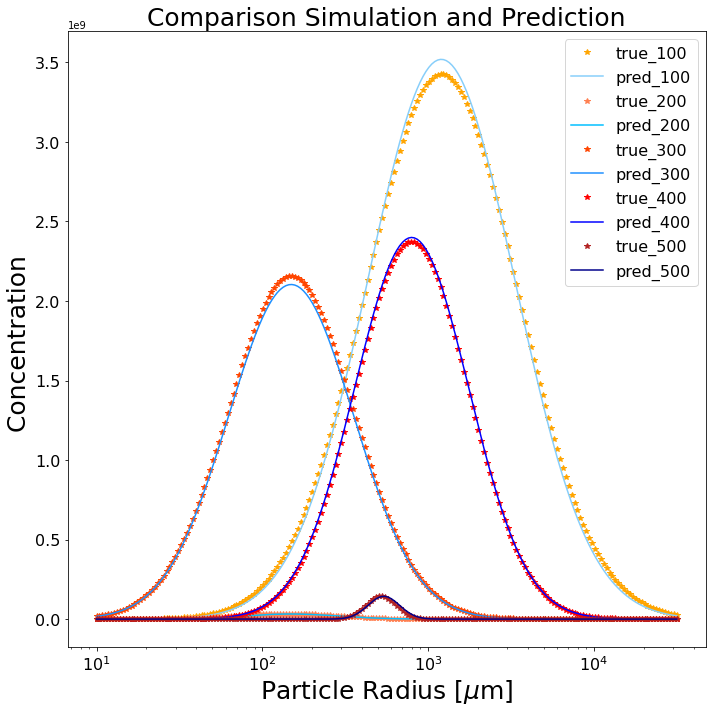

In [32]:
fig, ax = plt.subplots(figsize = (10,10))

colors_blue = ['lightskyblue','deepskyblue','dodgerblue','blue','darkblue']
colors_red = ['orange','coral','orangered','red','firebrick','darkred']

j = 0
for i  in presentation_plot_index:
    
    pdf1 = lognormal(D_array, dvar_test['DmedianN'].loc[i], dvar_test['GSD'].loc[i], dvar_test['Ntot'].loc[i])
    pdf2 = lognormal(D_array, dvar_pred['DmedianN'].loc[i], dvar_pred['GSD'].loc[i], dvar_pred['Ntot'].loc[i])
    
    ax.plot(D_array, pdf1*4/3.*np.pi*D_array**3., '*', color = colors_red[j], label = 'true_'+str(i))
    
    ax.plot(D_array, pdf2*4/3.*np.pi*D_array**3., color = colors_blue[j], label = 'pred_'+str(i))
    


    ax.legend(fontsize = 16)   
    j = j+1
ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/size_distribution_true_pred.jpg')

## 3. plot the biggest error 

In [33]:
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [34]:
testGSD1 = rel_error_fw['GSD'].values
testR = rel_error_fw['RmedianV'].values
testn = rel_error_fw['n'].values
testk = rel_error_fw['k'].values
testVtot = rel_error_fw['Vtot'].values
testGSD2 = np.log(dvar_test['RmedianV'].values)
testGSD3 = np.log(dvar_test['GSD'].values)


In [35]:
grid_x, grid_y = np.mgrid[100:5001:1, 1.01:3.1:0.01]

grid_x = np.log(grid_x)
grid_y = np.log(grid_y)
grid_GSD = griddata((testGSD2,testGSD3), testGSD1, (grid_x, grid_y), method='nearest')
grid_R = griddata((testGSD2,testGSD3), testR, (grid_x, grid_y), method='nearest')
grid_Vtot = griddata((testGSD2,testGSD3), testVtot, (grid_x, grid_y), method='nearest')
grid_n = griddata((testGSD2,testGSD3), testn, (grid_x, grid_y), method='nearest')
grid_k = griddata((testGSD2,testGSD3), testk, (grid_x, grid_y), method='nearest')


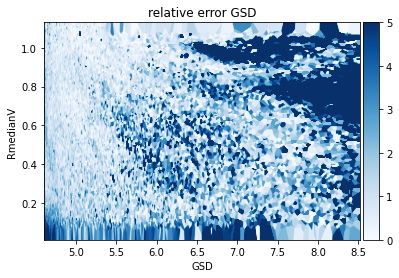

In [36]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_GSD.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error GSD')
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errGSD_GSD_R.jpg')

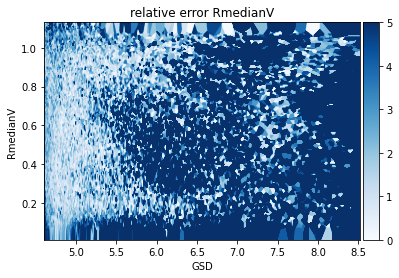

In [37]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_R.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error RmedianV')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errR_GSD_R.jpg')

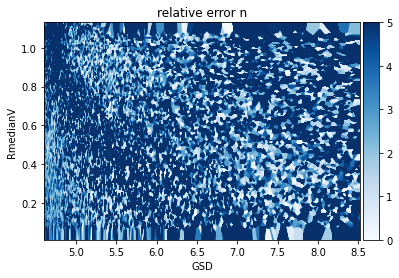

In [38]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_n.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error n')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errn_GSD_R.jpg')

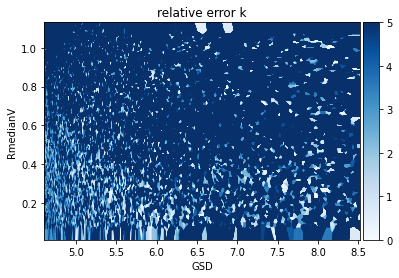

In [39]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_k.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')
ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error k')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errk_GSD_R.jpg')

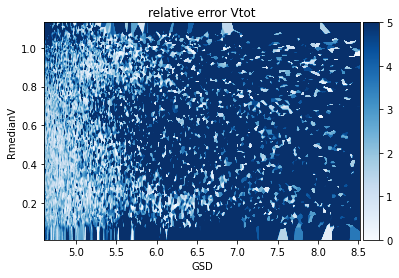

In [40]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(grid_Vtot.T, extent=(np.log(100),np.log(5000),np.log(1.01),np.log(3.1)),vmin=0, vmax=5,aspect = 'auto',cmap = 'Blues')

ax.set_xlabel('GSD')
ax.set_ylabel('RmedianV')
ax.set_title('relative error Vtot')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()
fig.savefig(f'{plot_dir}/rel_errVtot_GSD_R.jpg')

# Predict phase functions from aerosol properties

In [41]:
qoi_pred = surr_iv.predict(dvar_test_preprocessed)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)

In [42]:
F11_columns = [x for x in qoi_test.columns if 'F11' in x]
PPF_columns = [x for x in qoi_test.columns if 'PPF' in x]

In [43]:
qoi_test[F11_columns] = np.exp(qoi_test[F11_columns])
qoi_pred[F11_columns] = np.exp(qoi_pred[F11_columns])


In [44]:
## 1. calculate metrics

In [45]:
metric = RSquaredSeparated()
r2_adj_iv = metric.call(qoi_test.values, qoi_pred.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=qoi_test.columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Forward model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))
r2_adj_iv

Forward model:  R2_min =  1.0 ;  R2_max =  1.0


F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

   F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  F11_167  \
0     1.0  ...      1.0      1.0      1.0      1.0      1.0      1.0      1.0   

   F11_168  F11_169  F11_170  
0      1.0      1.0      1.0  

[1 rows x 152 columns]

In [46]:
iv_error_df = pd.DataFrame(columns = ['F11','PPF'])
iv_error_df.loc['r2']= [np.mean(r2_adj_iv[F11_columns].mean()),np.mean(r2_adj_iv[PPF_columns].mean())]
iv_error_df

F11  PPF
r2  1.0  NaN

In [47]:
r2_adj_iv.values

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1.]])

In [48]:
abs_error_iv = np.abs(qoi_pred - qoi_test)
abs_error_iv

F11_10      F11_11     F11_12     F11_13     F11_14     F11_15  \
0        0.396833    0.198880   0.103808   0.099152   0.170814   0.227669   
1        0.111131    0.033888   0.012576   0.008002   0.008659   0.011675   
2        3.487217    2.718268   2.769053   2.603738   2.758539   2.549051   
3        4.205546    2.969997   2.401972   2.182986   1.974045   1.958928   
4        8.915917    5.284543   5.611154   4.072785   4.322427   6.681011   
...           ...         ...        ...        ...        ...        ...   
19464  196.658852  104.142606  71.451483  60.305642  70.123787  75.375428   
19465    0.197064    0.076230   0.043124   0.028039   0.109043   0.089356   
19466    0.456241    0.274059   0.204111   0.212298   0.228101   0.256318   
19467  112.497078   87.102928  65.080365  49.452177  45.834102  51.230259   
19468    2.856443    2.362885   2.211897   1.860594   1.600319   1.715455   

          F11_16     F11_17     F11_18     F11_19  ...   F11_161   F11_162  \
0       0.270625   0.250825   0.197803   0.155731  ...  0.003713  0.003536   
1       0.014199   0.010289   0.008050   0.003979  ...  0.001247  0.001237   
2       3.115922   3.265552   2.643145   2.144972  ...  0.034311  0.023327   
3       1.807648   1.534477   1.368631   1.222681  ...  0.042220  0.039694   
4       9.198407   9.879439  11.495952  10.594593  ...  3.197302  2.593068   
...          ...        ...        ...        ...  ...       ...       ...   
19464  79.351423  78.125144  66.778228  50.591083  ...  0.132942  0.211516   
19465   0.158566   0.146993   0.017954   0.031449  ...  0.001481  0.001010   
19466   0.240120   0.208654   0.164868   0.151854  ...  0.007425  0.007589   
19467  55.970006  52.705158  51.735403  44.487396  ...  1.892281  1.886716   
19468   1.978318   1.627341   1.806357   1.606666  ...  0.319804  0.303089   

        F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0      0.003847  0.003627  0.003718  0.003773  0.003666  0.003615  0.003890   
1      0.001436  0.001414  0.001470  0.001665  0.001569  0.001734  0.001735   
2      0.011316  0.016712  0.005143  0.009295  0.000642  0.011465  0.019358   
3      0.044645  0.042697  0.041420  0.050162  0.045254  0.049269  0.043176   
4      3.512135  3.544849  3.295740  3.857264  3.745521  3.975592  3.595582   
...         ...       ...       ...       ...       ...       ...       ...   
19464  0.030758  0.013514  0.138380  0.063952  0.169005  0.235317  0.125135   
19465  0.002523  0.001602  0.001905  0.001272  0.001538  0.001182  0.002420   
19466  0.008485  0.008286  0.008534  0.009409  0.009330  0.010061  0.009771   
19467  2.120749  2.186783  2.184688  2.426405  2.472333  2.697861  2.566067   
19468  0.341970  0.340303  0.332743  0.371087  0.357693  0.401971  0.390566   

        F11_170  
0      0.003405  
1      0.001824  
2      0.013736  
3      0.042937  
4      3.816557  
...         ...  
19464  0.077225  
19465  0.001163  
19466  0.009909  
19467  2.608558  
19468  0.387851  

[19469 rows x 152 columns]

In [49]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.21    0.77    0.61    0.52    0.48    0.52    0.51    0.44    0.38   
75%   12.59    8.29    6.80    5.74    5.16    5.53    5.68    4.95    4.40   
90%   64.49   46.66   39.57   34.76   31.49   34.46   36.22   32.79   29.27   
95%  134.35  100.09   86.08   74.01   69.63   74.11   79.07   72.49   66.78   
99%  335.99  256.36  228.73  206.91  190.77  195.74  201.93  185.22  168.97   

     F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  \
50%    0.31  ...     0.03     0.03     0.03     0.03     0.03     0.04   
75%    3.61  ...     0.26     0.25     0.29     0.30     0.30     0.34   
90%   24.74  ...     1.45     1.39     1.60     1.60     1.61     1.82   
95%   56.56  ...     3.88     3.63     4.17     4.14     4.18     4.65   
99%  154.29  ...    16.74    16.49    17.99    18.02    18.10    19.71   

     F11_167  F11_168  F11_169  F11_170  
50%     0.03     0.04     0.04     0.04  
75%     0.33     0.36     0.35     0.35  
90%     1.80     1.96     1.91     1.93  
95%     4.57     4.96     4.87     5.00  
99%    19.82    21.02    20.90    21.51  

[5 rows x 152 columns]

In [50]:
iv_error_df.loc['abs error 90%']=[abs_error_table_iv[F11_columns].loc['90%'].max(), abs_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['abs error 95%']=[abs_error_table_iv[F11_columns].loc['95%'].max(), abs_error_table_iv[PPF_columns].loc['95%'].max()]


In [51]:
rel_error_iv = abs_error_iv / qoi_test * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=qoi_test.columns).abs()
rel_error_iv

F11_10    F11_11    F11_12    F11_13    F11_14    F11_15    F11_16  \
0      1.988833  1.087707  0.621211  0.650604  1.230965  1.804084  2.360020   
1      1.382927  0.523700  0.237922  0.182995  0.236665  0.377494  0.538099   
2      3.396067  2.707897  2.827834  2.731766  2.979819  2.841154  3.591278   
3      2.398152  1.881052  1.686252  1.695090  1.691772  1.848811  1.874667   
4      0.927132  0.560442  0.607473  0.450482  0.488813  0.772980  1.089429   
...         ...       ...       ...       ...       ...       ...       ...   
19464  2.505898  1.403121  1.019242  0.911780  1.124698  1.283309  1.434873   
19465  1.641617  0.645984  0.372350  0.247072  0.982135  0.823963  1.499295   
19466  1.365823  0.913582  0.757191  0.875588  1.044632  1.301592  1.349891   
19467  1.767208  1.556263  1.315450  1.125245  1.168738  1.457800  1.770413   
19468  1.211824  1.048077  1.025823  0.902171  0.811173  0.908801  1.095118   

         F11_17    F11_18    F11_19  ...   F11_161   F11_162   F11_163  \
0      2.408446  2.091801  1.813754  ...  1.856011  1.764069  1.914953   
1      0.453154  0.408778  0.231321  ...  1.128857  1.119872  1.299597   
2      3.900366  3.278650  2.769227  ...  2.197694  1.491525  0.721642   
3      1.744856  1.702696  1.660697  ...  1.077851  1.011160  1.134716   
4      1.198391  1.428843  1.349793  ...  1.588156  1.283770  1.733269   
...         ...       ...       ...  ...       ...       ...       ...   
19464  1.500988  1.363554  1.098110  ...  0.140267  0.222917  0.032378   
19465  1.427399  0.179330  0.323618  ...  0.574195  0.390062  0.970812   
19466  1.296382  1.130060  1.146155  ...  1.336187  1.363293  1.521170   
19467  1.846453  2.000586  1.892772  ...  2.041287  2.029111  2.273908   
19468  0.941012  1.090782  1.012825  ...  1.872087  1.768935  1.990055   

        F11_164   F11_165   F11_166   F11_167   F11_168   F11_169   F11_170  
0      1.801572  1.842503  1.865284  1.808111  1.778516  1.909646  1.667566  
1      1.279001  1.329191  1.505210  1.417266  1.565440  1.565814  1.644796  
2      1.062077  0.325565  0.585716  0.040226  0.715268  1.201463  0.848150  
3      1.082701  1.047873  1.266024  1.139448  1.237631  1.082089  1.073678  
4      1.744111  1.616868  1.887174  1.827784  1.935379  1.746461  1.849963  
...         ...       ...       ...       ...       ...       ...       ...  
19464  0.014209  0.145320  0.067077  0.177054  0.246233  0.130790  0.080627  
19465  0.614266  0.727529  0.484169  0.583481  0.446958  0.912586  0.437145  
19466  1.482637  1.523652  1.676304  1.658774  1.784774  1.729590  1.750185  
19467  2.337678  2.328535  2.578688  2.620114  2.851377  2.705064  2.743126  
19468  1.974775  1.925667  2.141993  2.059571  2.309099  2.238661  2.218566  

[19469 rows x 152 columns]

In [52]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_iv

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
50%    1.22    0.93    0.86    0.82    0.85    1.00    1.13    1.06    1.05   
75%    2.04    1.62    1.51    1.45    1.48    1.64    1.79    1.73    1.70   
90%    3.14    2.52    2.37    2.31    2.32    2.43    2.56    2.52    2.44   
95%    4.59    3.53    3.29    3.17    3.10    3.14    3.28    3.25    3.18   
99%   10.58    8.33    8.11    7.30    6.37    6.56    6.52    6.53    6.37   

     F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  \
50%    0.97  ...     1.36     1.32     1.50     1.53     1.53     1.72   
75%    1.58  ...     1.91     1.86     2.06     2.09     2.09     2.30   
90%    2.34  ...     2.59     2.52     2.74     2.77     2.77     3.01   
95%    3.11  ...     3.28     3.26     3.42     3.47     3.55     3.75   
99%    7.29  ...     7.19     7.40     7.75     7.91     7.99     7.94   

     F11_167  F11_168  F11_169  F11_170  
50%     1.68     1.80     1.76     1.76  
75%     2.27     2.40     2.35     2.38  
90%     3.00     3.17     3.12     3.21  
95%     3.80     3.96     4.01     4.18  
99%     8.35     8.75     9.39     9.98  

[5 rows x 152 columns]

In [53]:
iv_error_df.loc['rel error 90%']=[rel_error_table_iv[F11_columns].loc['90%'].max(), rel_error_table_iv[PPF_columns].loc['90%'].max()]
iv_error_df.loc['rel error 95%']=[rel_error_table_iv[F11_columns].loc['95%'].max(), rel_error_table_iv[PPF_columns].loc['95%'].max()]


In [54]:

abs_error_table_F11 = abs_error_table_iv[F11_columns]
print('Absolute error F11')
print(abs_error_table_F11.max(axis = 1))
abs_error_table_PPF = abs_error_table_iv[PPF_columns]
print('Absolute error PPF')
print(abs_error_table_PPF.max(axis = 1))
rel_error_table_F11 = rel_error_table_iv[F11_columns]
print('Relative error F11')
print(rel_error_table_F11.max(axis = 1))
rel_error_table_PPF = rel_error_table_iv[PPF_columns]
print('Relative error PPF')
print(rel_error_table_PPF.max(axis = 1))


Absolute error F11
50%      1.21
75%     12.59
90%     64.49
95%    134.35
99%    335.99
dtype: float64
Absolute error PPF
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64
Relative error F11
50%     1.80
75%     2.40
90%     3.21
95%     4.59
99%    10.58
dtype: float64
Relative error PPF
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


In [55]:
wMAPE_qoi = wmape(qoi_test, qoi_pred)
wMAPE_qoi = pd.DataFrame(wMAPE_qoi).T
np.round(wMAPE_qoi, decimals =2)

F11_10  F11_11  F11_12  F11_13  F11_14  F11_15  F11_16  F11_17  F11_18  \
0    1.77    1.45    1.39    1.33    1.34    1.54    1.72    1.69    1.66   

   F11_19  ...  F11_161  F11_162  F11_163  F11_164  F11_165  F11_166  F11_167  \
0    1.55  ...     1.99      1.9     2.12     2.13     2.15     2.36     2.36   

   F11_168  F11_169  F11_170  
0     2.52     2.46     2.52  

[1 rows x 152 columns]

In [56]:
iv_error_df.loc['wmape']=[wMAPE_qoi[F11_columns].mean().mean(),wMAPE_qoi[PPF_columns].mean().mean()]
iv_error_df

F11  PPF
r2               1.000000  NaN
abs error 90%   64.490000  NaN
abs error 95%  134.350000  NaN
rel error 90%    3.210000  NaN
rel error 95%    4.590000  NaN
wmape            1.624599  NaN

In [57]:
iv_error_df.to_csv(f'{plot_dir}/iv_error_df.csv')

## 2. plots

In [58]:
theta = []
for i in range(10,86):
    theta.append(i)
for i in range(95,171):
    theta.append(i)

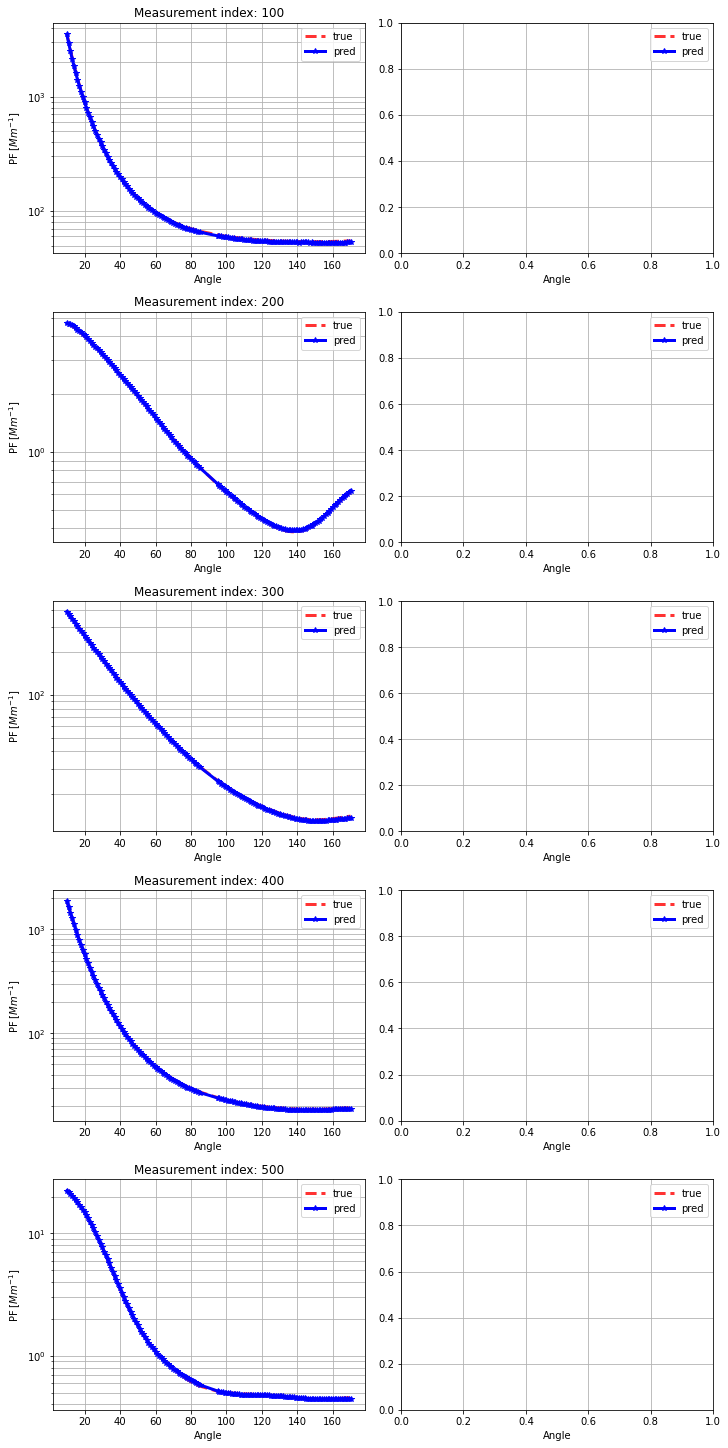

In [59]:
presentation_plot_index = [100,200,300,400,500]
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(10, 20), constrained_layout=True)
nr = 0
for index in presentation_plot_index:
    axs[nr,0].set_title('Measurement index: '+str(index))

    pms_hdf_plot, = axs[nr,0].plot(theta, qoi_test[F11_columns].loc[index], ls='--', markersize = 5, lw='3', c='r', alpha=0.8, label='true')
  #  pms_hdf_plot, = axs[nr,1].plot(theta, qoi_test[PPF_columns].loc[index], ls='--', lw='3', c='r', alpha=0.8, label='true')

    meas_hdf_plot, = axs[nr,0].plot(theta, qoi_pred[F11_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
  #  meas_hdf_plot, = axs[nr,1].plot(theta, qoi_pred[PPF_columns].loc[index],'*',ls = '-',lw ='3', c= 'b', label = 'pred')
    

    axs[nr,0].set_ylabel('PF [$Mm^{-1}$]')
  #  axs[nr,1].set_ylabel('PPF [-]')
  #  axs[nr,1].set_ylim(-1.1, 1.1)
    axs[nr,0].set_yscale('log')
    for ax in axs.reshape(-1):
        ax.set_xlabel('Angle')
        ax.legend(handles=[pms_hdf_plot,meas_hdf_plot])
        ax.grid(which='both')
    nr = nr+1
fig.savefig(f'{plot_dir}/phase_functions_true_pred.jpg')